Práctica Final NLP José Carlos Amo Pérez
## 2. Etapa de preprocesado de texto

Citation:

<small>Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering
R. He, J. McAuley
WWW, 2016
https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf</small>

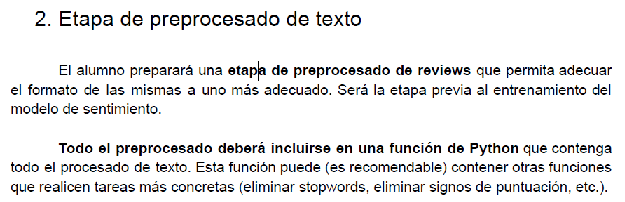

In [1]:
# Carga e importación de librerias:
!python -m spacy download en_core_web_sm
!pip install stop_words
!pip install num2words
!pip install contractions

import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
import spacy
import unicodedata
from num2words import num2words
from stop_words import get_stop_words
import string
import re
import pandas as pd
import numpy as np
import gzip
import en_core_web_sm
from collections import Counter
import matplotlib.pyplot as plt
from nltk import ngrams
from nltk.probability import FreqDist
from nltk import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
import io
import decimal
from decimal import Decimal, InvalidOperation
import contractions
from nltk.tokenize.treebank import TreebankWordDetokenizer
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from collections import defaultdict
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
import random
from nltk.corpus import wordnet as wn


2023-03-09 17:13:41.167601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 17:13:42.094801: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-09 17:13:42.094914: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-09 17:13:42.094935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Cargo el conjunto de datos que estoy manejando tras la etapa de Exploración
# Este df se diferencia del original en que los nombres de las columnas se han traducido y
# en que se han añadido dos nuevas columnas "Palabras#" y "Frases#"
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

df = pd.read_csv('/content/gdrive/My Drive/NLP/df_ya_explorado.csv')

Mounted at /content/gdrive


In [21]:
print(df.shape)


(10261, 11)


In [22]:
df.head(3)

,IDRevisor,IDProducto,Revisor,Utilidad,Comentario,Calificación,Resumen,HoraUnix,Fecha,Palabras#,Frases#
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,",5.0,good,1393545600,"02 28, 2014",57,4
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]","The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]",5.0,Jake,1363392000,"03 16, 2013",117,4
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]","The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. The double cloth filter blocks the pops and lets the voice through with no coloration. The metal clamp mount attaches to the mike stand secure enough to keep it attached. The goose neck needs a little coaxing to stay where you put it.",5.0,It Does The Job Well,1377648000,"08 28, 2013",82,4


Hago operaciones previas de preparación

In [23]:
# Muevo "calificacion" a la columna 0 pues es "la variable dependiente"
df = df.reindex(columns=['Calificación', 'Comentario', 'IDRevisor', 'IDProducto']) 
# Elimino valores NaN y duplicados
df= df.dropna(how='any').drop_duplicates()

In [24]:
print(df.shape)

(10254, 4)


Voy a balancear las clases porque vimos que estaban muy desequilibradas y también voy a aleatorizar el orden de las filas para evitar que al dividir las datos en train y test se repartan de nuevo de forma desequilibrada.

In [25]:
# Modifico los valores de la columna "Calificación" (valores 4.0 ó 5.0 los convierte en 1, el resto en 0)
def convertir_calificacion(valor):
    if valor == 4.0 or valor == 5.0:
        return 1
    else:
        return 0

df["Calificación"] = df["Calificación"].apply(convertir_calificacion)

In [26]:
# Función para balancear las clases y aleatorizar el orden de las filas del dataframe resultante
def balancea_el_muestreo(df, columna):

    # Contar el número de instancias por valor de etiqueta
    contador = df[columna].value_counts()

    # Determinar el número mínimo de instancias en una clase
    min_count = np.min(contador)

    # Crear un nuevo dataframe con una cantidad igual de instancias por clase
    df_balanceado = pd.DataFrame()
    for val in contador.index:
        # Filtrar instancias por valor de etiqueta
        df_val = df[df[columna] == val]
        
        # Seleccionar un subconjunto aleatorio de instancias
        df_val_sampleado = df_val.sample(n=min_count, random_state=42)
        
        # Agregar al dataframe balanceado
        df_balanceado = pd.concat([df_balanceado, df_val_sampleado])
        
    # Aleatorizar el orden de aparición de las filas
    df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df_balanceado

Uso la función de blanceo y aleatorización:

In [27]:
df = balancea_el_muestreo(df, "Calificación")

In [29]:
print(df.shape)

(2478, 4)


He reducido la dimensionalidad de 10261 a 2478 filas

In [30]:
def porcentaje_valores(df, columna):
    # Contar los valores únicos de la columna
    conteo = df[columna].value_counts()
    
    # Calcular el porcentaje de valores 0 y 1
    porc_0 = 100 * conteo[0] / len(df)
    porc_1 = 100 * conteo[1] / len(df)
    
    # Imprimir los resultados
    print("Valores 0: {:.2f}%".format(porc_0))
    print("Valores 1: {:.2f}%".format(porc_1))

porcentaje_valores(df, "Calificación")


Valores 0: 50.00%
Valores 1: 50.00%


Ahora el balanceo es perfecto, a costa eso si de reducir la dimensionalidad. Lo cual puede desembocar en un aprendiaje de peor calidad


Voy a incluir el contenido de las columnas IDRevisor e IDProducto en la columna "Comentario" como si fueran un token más. La idea es que el modelo pueda jugar también con el concepto de que quizá un mismo artículo o un mismo evaluador tienden a estar asociados a una misma "Calificación".

In [31]:
# Función que toma cada valor en la columna "IDProducto" y en la columna "IDRevisor" y los añade como
# dos palabras más al inicio de la columna "Comentario" del dataframe
def add_id_to_comment(row):
    new_comment = f"{row['IDProducto']} {row['IDRevisor']} {row['Comentario']}"
    row['Comentario'] = new_comment
    return row


Añado los valores de IDProducto pasado a letras e IDRevisor como una palabra más en "Comentario"

In [32]:
# df = id_to_letters(df, "IDProducto")
df = df.apply(add_id_to_comment, axis=1)

In [33]:
df.head(2)

,Calificación,Comentario,IDRevisor,IDProducto
0,0,"B005MR6IHK A3VG7F7SZUK87S I liked this tuner, the look, the size, the ease of use, the quality performance, until it died. I think what happened is I just left it on too long. My problem was that in order to turn the power off you have to hold the power button rather than simply pressing and releasing it. Since it died that first time, it doesn't seem to perform the same. I also haven't really paid much attention to it since it died because I sent another similar tuner in for replacement, and I got an acoustic guitar that has an on-board tuner and a tuner pedal for electric guitar.I wouldn't recommend against this product. Just remember to hold the power button to turn it off.",A3VG7F7SZUK87S,B005MR6IHK
1,1,B004Z17008 A12O5B8XNKNBOL Works great and easy to use. It also seems to be very accurate. Definitely worth the money!! (Should also work for any stringed instrument),A12O5B8XNKNBOL,B004Z17008


In [34]:
# Reduzco el df a las dos variables que me interesan: "Calificación" y "Comentario" eliminando ya "IDRevisor' e 'IDProducto'"
df = df.drop(df.columns.difference(['Calificación', 'Comentario']), axis=1)

Incorporo las funciones de procesado que luego voy a necesitar

In [42]:
# Cargo el modelo de Spacy en inglés
nlp = spacy.load('en_core_web_sm')

# Defino la lista de stop words en inglés
sw_list = get_stop_words('en')

# Creo una instancia de la clase WordNetLemmatizer del paquete nltk.stem que 
# luego usaré para la lematización
lemmatizer = WordNetLemmatizer()

# Función que convierte un texto a minúsculas
def minusculiza(text):
    doc = nlp(text)
    return ' '.join([token.text.lower() for token in doc])

# Función que expande las formas contraidas del inglés
def sin_contraccion(text):
    text = contractions.fix(text)
    tokens = word_tokenize(text)
    text = TreebankWordDetokenizer().detokenize(tokens)
    return text

# Función que elimina signos de puntuación:
def sin_puntuacion(text):
    doc = nlp(text)
    return ' '.join(token.text for token in doc if not (token.text in string.punctuation and token.text != ","))

# Función que elimina caracteres especiales
def quita_caracteres_especiales(text):
    caracteres_eliminar = "!@#$%^&*()-_+={}[]|\;:'\"<>,.?/"
    for caracter in caracteres_eliminar:
        text = text.replace(caracter, ' ')
    return text

# Función que convierte números a texto cardinal:
def num2cardinal(text):
    def replace(match):
        try:
            num = match.group()
            if "." in num:
                return num
            else:
                return num2words(Decimal(num), lang='en')
        except InvalidOperation:
            return match.group()
    return re.sub(r"\b\d+\b", replace, text)

# Función que elimina stop words
def sin_sw(text, sw_list):
    return ' '.join([word for word in text.split() if word not in sw_list])

# Función que elimina espacios en blanco al inicio y al final de un texto
def sin_espacios(text):
    doc = nlp(text)
    return doc.text.strip()

# Función que elimina espacios duplicados en un texto
def sin_dobles_espacios(text):
    return re.sub(r'\s{2,}', ' ', text)

def elimina_palabras_de_longitud_1(texto):
    palabras = texto.split()
    sin_palabras_de_longitud_1 = []
    for palabra in palabras:
        if len(palabra) > 1:
            sin_palabras_de_longitud_1.append(palabra)
        elif len(palabra) == 1 and not palabra.isalpha():
            continue
    return ' '.join(sin_palabras_de_longitud_1)

# Funcion para lemmatizar basada en NLTK
# Función que devuelve el tag correcto de WordNet en base al tag PoS de nltk y que se usará en el lematizador
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Función que lematiza el texto y devuelve el resultado.
def lematiza(text):
    tokens = nltk.word_tokenize(text.lower())
    tagged_tokens = nltk.pos_tag(tokens)
    wordnet_pos_tags = [get_wordnet_pos(tag) for word, tag in tagged_tokens]
    lemmatizer = nltk.WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos=tag) if tag is not None else word for word, tag in zip(tokens, wordnet_pos_tags)]
    return " ".join(lemmas)




Genero una fuinción para el preprocesado propiamente dicho:

In [43]:
# Defino la función que hace el preprocesado:
def preprocesado(dataf):
    # Proceso
    dataf = dataf.assign(Comentario = dataf['Comentario'].apply(minusculiza).apply(sin_espacios).apply(sin_dobles_espacios).apply(sin_contraccion).apply(num2cardinal).apply(sin_puntuacion).apply(quita_caracteres_especiales).apply(elimina_palabras_de_longitud_1).apply(lambda x: sin_sw(x, sw_list)))
    # Lematizo
    dataf['Comentario'] = dataf['Comentario'].apply(lematiza)
    # Guardo el df modificado en un nuevo archivo csv
    dataf.to_csv('/content/gdrive/My Drive/NLP/df_procesado.csv', index=False) 
    return dataf

 

In [44]:
# Miro los primeros 3 valores a ver cómo son antes de preprocesar
n = 3
def comentarios(df, n):
  pd.set_option('display.max_colwidth', None)
  max_width = max([len(str(comment)) for comment in df['Comentario']])
  comments = []
  for comment in df['Comentario'].head(n):
      comments.append(comment.ljust(max_width))
  comments_str = '\n'.join(comments)
  return comments_str

comentarios_sin_procesar = comentarios(df, n)
print(comentarios_sin_procesar)



B005MR6IHK A3VG7F7SZUK87S I liked this tuner, the look, the size, the ease of use, the quality performance, until it died. I think what happened is I just left it on too long. My problem was that in order to turn the power off you have to hold the power button rather than simply pressing and releasing it. Since it died that first time, it doesn't seem to perform the same. I also haven't really paid much attention to it since it died because I sent another similar tuner in for replacement, and I got an acoustic guitar that has an on-board tuner and a tuner pedal for electric guitar.I wouldn't recommend against this product. Just remember to hold the power button to turn it off.                                                                                                                                                                                                                                                                                                                           

In [45]:
# Paso el dataframe por la función de preprocesado que he definido
df = preprocesado(df)

In [46]:
# Miro la diferencia antes y despues de preprocesar para ver como queda "Comentario" una vez procesada
comentarios_ya_procesados = comentarios(df, n=3)
print(f'Antes de procesar los comentasios eran así:\n{comentarios_sin_procesar}')
print(f'\nY ujna vez procesados son así:\n{comentarios_ya_procesados}')

Antes de procesar los comentasios eran así:
B005MR6IHK A3VG7F7SZUK87S I liked this tuner, the look, the size, the ease of use, the quality performance, until it died. I think what happened is I just left it on too long. My problem was that in order to turn the power off you have to hold the power button rather than simply pressing and releasing it. Since it died that first time, it doesn't seem to perform the same. I also haven't really paid much attention to it since it died because I sent another similar tuner in for replacement, and I got an acoustic guitar that has an on-board tuner and a tuner pedal for electric guitar.I wouldn't recommend against this product. Just remember to hold the power button to turn it off.                                                                                                                                                                                                                                                                               

Creo que no tiene mala pinta, veremos luego al meterlo a un modelo.

<font color="red">**Retomo aqui el ejercicio de los word embeddings que dejé pendiente en el modulo anterior.**</font>

Defino hiperparámetros

In [47]:
cores = multiprocessing.cpu_count() # Contamos el número de cores en el ordenador
w2v_model = Word2Vec(size=600,   #significa que el vocabulario se representará como un vector de 500 dimensiones (por defecto = 100)
                     window=2,   #valor por defecto =>el modelo considera las 2 palabras anteriores y posteriores a la palabra objetivo.
                     min_count=30,  #las palabras que aparecen menos de 30 veces en el corpus se ignoran en el entrenamiento (por defecto=5)
                     sg=1,           #elijo algoritmo Skip-gram porque es más preciso
                     hs=0,          #elijo muestreo negativo
                     negative=5,     #valor por defecto =>por cada palabra de contexto, se muestrean 5 palabras que no están en el contexto
                     sample=1e-7,   #frecuencia con que se reduce el muestreo de palabras más frecuentes durante el entrenamiento
                     alpha=0.0001,    #tasa de aprendizaje inicial del modelo
                     min_alpha=0.0001, #tasa de aprendizaje mínima permitida, para obligar a que el modelo converja
                     workers=cores-1)  #número de hilos de ejecución


He usado varias combianciones de hiperparámetros y, sinc3eramente, logro empeorar los resultados pero no mejorarlos.

Construyo la tabla con el vocabulario

In [48]:
# Creo una lista llamada sent que contiene una lista de palabras tokenizadas para cada comentario de "ComenLematizado" en df
sent = [row.split() for row in df['Comentario']]
# Construyo el vocabulario a partir de los datos de entrenamiento (sent) usando el método build_vocab del modelo Word2Vec
w2v_model.build_vocab(sent, progress_per=10000)  #progress_per = 10000 establece mostrar el progreso cada 10000 palabras procesadas

El vocabulario construido por build_vocab() consiste en todas las palabras únicas en los datos de entrenamiento que cumplen con los parámetros especificados en la inicialización del modelo (size, window, min_count, hs, etc.). Después de construir el vocabulario, ya puedo entrenar el modelo.

In [49]:
# Entreno el modelo
w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=200, report_delay=1)

(149134, 26446400)

Los valores 149134 y 26446400 indican que el número de palabras totales que fueron procesadas durante el entrenamiento del modelo fue de 149134 y que el número total de "palabras objetivo" que fueron predichas por el modelo durante el entrenamiento fue de 26446400

Voy a imprimr por consola las 10 palabras más similares a 5 palabras elegidas al azar del corpus.

In [52]:
# Elijo 5 palabras
palabras_azar = ['ball', 'patch', 'mind', 'guitar', 'drum', 'sound']

# Encuntro las 10 palabras más similares para cada palabra de las anteriores
for word in palabras_azar:
    try:
    # bloque de código a probar en busca de errores
      print(f'\nPalabra elegida: {word}')
      most_similar = w2v_model.wv.most_similar(positive=[word], topn=10)
      print('Palabras más similares:')
      for i, (similar_word, score) in enumerate(most_similar, start=1):
          print(f'{i}. {similar_word} ({score:.2f})')
    except:
    # bloque de código a ejecutar en caso de que se produzca una excepción 
      print(f'\nLa palabra elegida {word} no está en el diccionario')





Palabra elegida: ball
Palabras más similares:
1. jam (0.13)
2. screen (0.11)
3. often (0.11)
4. wish (0.10)
5. wrong (0.10)
6. spring (0.10)
7. order (0.10)
8. cloth (0.09)
9. ok (0.09)
10. just (0.09)

Palabra elegida: patch
Palabras más similares:
1. material (0.13)
2. sometimes (0.13)
3. deal (0.11)
4. glue (0.11)
5. professional (0.10)
6. spot (0.10)
7. near (0.10)
8. knob (0.09)
9. nt (0.09)
10. joyo (0.09)

Palabra elegida: mind
Palabras más similares:
1. input (0.13)
2. watt (0.13)
3. zero (0.12)
4. think (0.10)
5. jazz (0.10)
6. pull (0.10)
7. hit (0.10)
8. boss (0.09)
9. include (0.09)
10. hard (0.09)

Palabra elegida: guitar
Palabras más similares:
1. amount (0.11)
2. port (0.11)
3. thing (0.11)
4. ukulele (0.10)
5. button (0.10)
6. piece (0.10)
7. bass (0.10)
8. rest (0.10)
9. low (0.09)
10. extra (0.09)

Palabra elegida: drum
Palabras más similares:
1. awesome (0.11)
2. will (0.11)
3. damage (0.10)
4. multiple (0.10)
5. difference (0.09)
6. rubber (0.09)
7. instead (0.09)


Como vemos hay valores muy bajos lo cual indica que no hay una similitud muy significativa entre las palabras 'ball', 'patch', 'mind', 'guitar', 'drum', 'sound' en términos de su uso o su frecuencia de aparicion en el corpus de entrenamiento